# Phase shift and Hilbert Transform

Saleh Rezaeiravesh, saleh.rezaeiravesh@manchester.ac.uk
___

**Aim:** Demonstrate the difference between standard TE and phase TE for time series with and without phase shift. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

import sys
sys.path.append('../core/')
from te import bi_te
from entropy import entropy
from pseudoTE import pTE

$$
x_i = 0.5 x_{i-1} - 0.3x_{i-5} +0.1y_{i-2}+0.1 x_{i-2}^2 + 0.4 y_{i-1}y_{i-2} + \varepsilon_{x,i}
$$

$$
y_i = \sin(6\pi t+\varphi) + \varepsilon_{y,i}
$$

By Construction:
* The maximum TE is expected at lag 5 (observe $x_{i-5}$).
* The TE $x\to y $ should be negligible. 

In [2]:
def sampleGen(n,phaseShift=0):
    """
    Inspired from M10 model in Selini & Masollor 2021
    """
    np.random.seed(1000)
    
    x = np.zeros((int(2*n),2))    
    t = np.linspace(0.,10.,int(2*n))
    
    #for j in range(2):
    #    x[j,0]=np.random.rand(2)  #initial data for x1                
    
    #Noise
    rho_eps=0.7  #correlation between the noises
    sdev1 = .2
    sdev2 = .2
    covMat_eps = np.asarray([[sdev1**2,rho_eps*sdev1*sdev2],[rho_eps*sdev1*sdev2,sdev2**2]])
    eps = np.random.multivariate_normal(np.zeros(2), covMat_eps, 2*n).T
    
    #sample generator
    for i in range(2,2*n):
        x[i,0] = 0.5*x[i-1,0] - 0.3*x[i-5,0] +0.1*x[i-2,1] +0.1*x[i-2,0]**2. + 0.4*x[i-1,1]*x[i-2,1] + eps[0,i]
        x[i,1] = np.sin(6.*np.pi*t[i]+phaseShift) + eps[1,i]
        
    return x[n:,:]    

Hilbert transform of a time series:

In [3]:
def hilbert(X):
    """
    Hilbert transform of time sereies X; returns phase and amplitude time series
    """    
    h = signal.hilbert(X) #complex signal
    s = abs(h)  #amplitude of the complex signal
    #a =np.angle(h, deg=False)
    a = np.arctan2(h.imag,h.real)  #phase of the complex signal
    
    return s,a

Estimate TE between $x$ and $y$ at a set of given lags

In [4]:
def te_lagList(x,y,lagList,k=10):
    
    te_ksg_xy=[]
    te_ksg_yx=[]

    for lag in lagList:      
        te1_ = bi_te(x, y, embDim=lag).ksg(k)
        te_ksg_xy.append(te1_)
    
        te2_ = bi_te(y, x, embDim=lag).ksg(k)
        te_ksg_yx.append(te2_)
    
    te_ksg_xy = np.array(te_ksg_xy)    
    te_ksg_yx = np.array(te_ksg_yx)
    
    return te_ksg_xy, te_ksg_yx

## Generate data

Set the value of $\varphi$, the phase shift and generate samples:

In [5]:
x = sampleGen(n=1000,phaseShift=0.0)         # times series without phase shift 
z = sampleGen(n=1000,phaseShift=0.6*np.pi)   # time series with phase shift 

n = x.shape[0]
t = np.arange(n)

Note that the phase shift in $y$, will influence the samples of $x$, as well (by construction). 

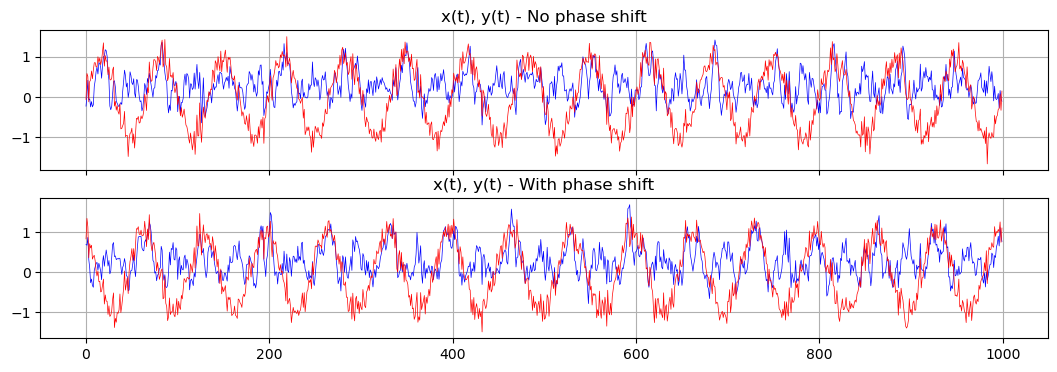

In [6]:
plt.figure(figsize=(13,4))

plt.subplot(211)
plt.title('x(t), y(t) - No phase shift')
plt.plot(t,x[:,0],'-b',lw=0.5)
plt.plot(t,x[:,1],'-r',lw=0.5)
plt.tick_params('x', labelbottom=False)
plt.grid(0.2)

plt.subplot(212)
plt.title('x(t), y(t) - With phase shift')
plt.plot(t,z[:,0],'-b',lw=0.5)
plt.plot(t,z[:,1],'-r',lw=0.5)
plt.grid(0.2)
plt.show()

Hilbert transform of time series, with and without phase shift

In [7]:
#no phase shift
sx1,ax1 = hilbert(x[:,0])
sx2,ax2 = hilbert(x[:,1])

#with phase shift
sz1,az1 = hilbert(z[:,0])
sz2,az2 = hilbert(z[:,1])

Plotting **phase time series**

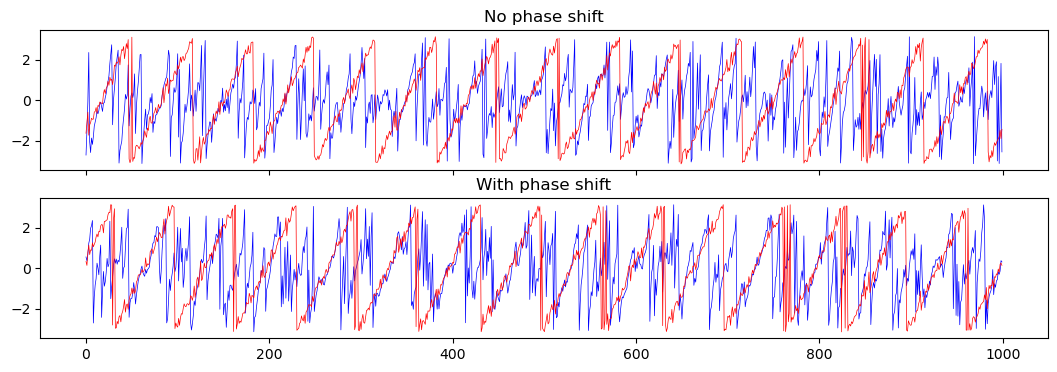

In [8]:
plt.figure(figsize=(13,4))

plt.subplot(211)
plt.title('No phase shift')
plt.plot(t,ax1,'-b',lw=0.5)
plt.plot(t,ax2,'-r',lw=0.5)
plt.tick_params('x', labelbottom=False)

plt.subplot(212)
plt.title('With phase shift')
plt.plot(t,az1,'-b',lw=0.5)
plt.plot(t,az2,'-r',lw=0.5)
plt.show()

## TE

In [9]:
lagList=[1,2,3,4,5,7,9,11,15,20,30]   #lags at which TE will be estimated

**No phase shift**: TE between time series, and phase TE between phases associated with time series

In [10]:
te_x1_x2, te_x2_x1 = te_lagList(x[:,0],x[:,1],lagList,k=10)
te_ax1_ax2, te_ax2_ax1 = te_lagList(ax1,ax2,lagList,k=10)

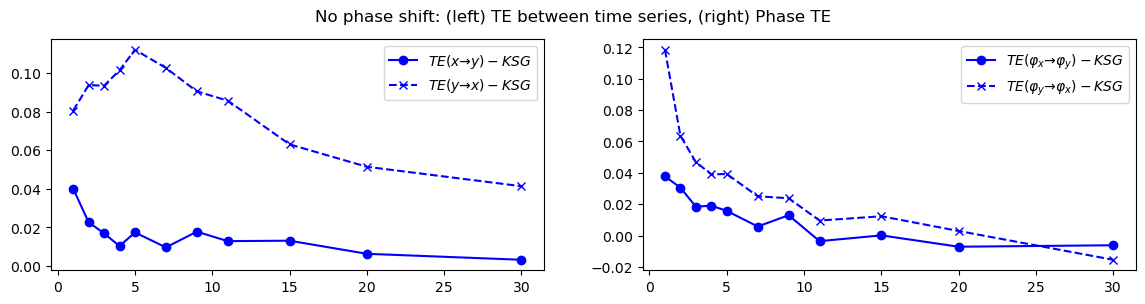

In [11]:
fig = plt.figure(figsize=(14,3))
fig.suptitle('No phase shift: (left) TE between time series, (right) Phase TE ')

plt.subplot(121)
plt.plot(lagList,te_x1_x2,'-ob',label=r'$TE(x\to y) - KSG$')    
plt.plot(lagList,te_x2_x1,'--xb',label=r'$TE(y\to x) - KSG$')    
plt.legend(loc='best')

plt.subplot(122)
plt.plot(lagList,te_ax1_ax2,'-ob',label=r'$TE(\varphi_x\to \varphi_y) - KSG$')    
plt.plot(lagList,te_ax2_ax1,'--xb',label=r'$TE(\varphi_y\to \varphi_x) - KSG$')    
plt.legend(loc='best')

plt.show()

**Phase shifted**: TE between time series, and phase TE between phases associated with time series

In [12]:
te_z1_z2, te_z2_z1 = te_lagList(z[:,0],z[:,1],lagList,k=10)
te_az1_az2, te_az2_az1 = te_lagList(az1,az2,lagList,k=10)

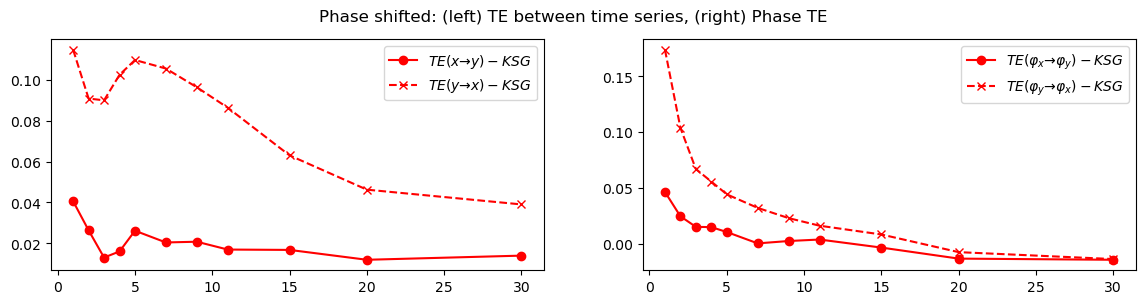

In [13]:
fig = plt.figure(figsize=(14,3))
fig.suptitle('Phase shifted: (left) TE between time series, (right) Phase TE ')

plt.subplot(121)
plt.plot(lagList,te_z1_z2,'-or',label=r'$TE(x\to y) - KSG$')    
plt.plot(lagList,te_z2_z1,'--xr',label=r'$TE(y\to x) - KSG$')    
plt.legend(loc='best')

plt.subplot(122)
plt.plot(lagList,te_az1_az2,'-or',label=r'$TE(\varphi_x\to \varphi_y) - KSG$')    
plt.plot(lagList,te_az2_az1,'--xr',label=r'$TE(\varphi_y\to \varphi_x) - KSG$')    
plt.legend(loc='best')

plt.show()

### Conclusions
1. Phase shift can affect the value of TE and phase TE. 
2. Phase shift does not affect the lag at which maximum TE or phase TE happens. 
3. The lag at which maximum TE happens can be different from the lag associated with the maximum phase TE.
3. Both TE and phase TE correctly show the dominant direction of information transfer between two time series. 